## 4. Итоговый проект

#### Импорт библиотек

In [364]:
import pandas as pd
import numpy as np
import psycopg2
from dotenv import load_dotenv
from pandas.errors import SettingWithCopyWarning

from IPython.display import Image, display
from pprint import pprint
import re
import warnings
import os

#### Глобальные настройки

In [365]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

load_dotenv()

True

#### Загрузка данных для дальнейшей обработки и анализа.

In [366]:
df = pd.read_csv('../datasets/preprocessed_student_data.csv')

#### Просмотр данных

In [367]:
info_df = {}

info_df['0. Размер DataFrame'] = df.shape
info_df['1. Индексы DataFrame'] = df.index
info_df['2. Колонки DataFrame'] = list(df.columns.values)
info_df['3. Числовые колонки'] = dict(df.select_dtypes(include=[int, float, complex]).dtypes)
info_df['4. Строковые колонки'] = dict(df.select_dtypes(include=[object]).dtypes)
info_df['5. Колонки с пропусками'] = list(df.columns[df.isnull().any()])
info_df['6. Строки с пропусками'] = list(df[df.isnull().any(axis=1)].index.values)
info_df['7. Колличество строк без пропусков'] = len(df.value_counts())
info_df['8. Колличество полных дубликатов'] = len(df[df.duplicated(keep=False)])
info_df['9. Колличество занимаемой памяти'] = f"{round(df.memory_usage(deep=True).sum() / 1048576, 2)} мегабайт"

types_column = dict(zip(df.columns, df.dtypes))

pprint(info_df, width=400, compact=True)
print()
pprint(types_column)

display(df.head(3))

{'0. Размер DataFrame': (103, 12),
 '1. Индексы DataFrame': RangeIndex(start=0, stop=103, step=1),
 '2. Колонки DataFrame': ['student_id', 'name', 'age', 'gender', 'grade', 'major', 'gpa', 'attendance_rate', 'extracurricular_activities', 'study_hours_per_week', 'sleep_hours_per_day', 'distance_from_home_km'],
 '3. Числовые колонки': {'age': dtype('float64'), 'attendance_rate': dtype('int64'), 'distance_from_home_km': dtype('float64'), 'gpa': dtype('float64'), 'sleep_hours_per_day': dtype('float64'), 'study_hours_per_week': dtype('int64')},
 '4. Строковые колонки': {'extracurricular_activities': dtype('O'), 'gender': dtype('O'), 'grade': dtype('O'), 'major': dtype('O'), 'name': dtype('O'), 'student_id': dtype('O')},
 '5. Колонки с пропусками': ['age', 'gender', 'gpa', 'extracurricular_activities'],
 '6. Строки с пропусками': [0, 1, 2, 5, 6, 9, 11, 14, 17, 18, 20, 22, 24, 25, 27, 32, 38, 39, 40, 48, 49, 54, 58, 60, 63, 64, 66, 67, 68, 74, 80, 81, 84, 85, 88, 89, 91, 94, 95, 97],
 '7. Кол

,student_id,name,age,gender,grade,major,gpa,attendance_rate,extracurricular_activities,study_hours_per_week,sleep_hours_per_day,distance_from_home_km
0,d12413d6-3617-4390-a956-0e56342dc881,Tracy Ramos,22.0,NaN,A,Science,2.99,70,Music,12,8.504874,21.75
1,a3176691-10eb-47aa-9aae-72660937d95a,Valerie Price,18.0,Female,C,Math,2.98,81,NaN,10,6.992983,9.34
2,31bfc4cd-3137-4d32-b920-665cce9dce0d,Zachary Grimes,25.0,NaN,C,Science,3.28,91,Sports,27,5.613224,19.45


```
student_id.................. Идентификатор студента
name........................ Имя студента
age......................... Возраст студента	
gender...................... Пол студента
grade....................... Класс студента
major....................... Главный урок
gpa......................... Средний балл студента
attendance_rate............. Уровень посещаемости студента
extracurricular_activities.. Внеклассные занятия студента
study_hours_per_week........ Количество часов учебы в неделю студента
sleep_hours_per_day......... Количество часов сна в день студента
distance_from_home_km....... Удаленность от дома студента
```

#### Предварительная обработка данных
- Удаляем дубликаты
- Разделяем имена и возраст
- Избавляемся от пропусков и неверных значений
- Корректировка типов данных
- Неверные данные (данные которые не могут быть)
6. Пункт вообще не понятен , что значит не соответствие , это внеклассовое занятие , чем хочет тем и будет заниматься

In [368]:
# Удаляем дубликаты
df = df[~df.duplicated(keep=False)]

# Разделяем имена и возраст
pattern_name = r'([a-zA-Z]+\s[a-zA-Z]+)'
pattern_age = r'([0-9]+\.[0-9]+)'
name_age = df.loc[:, 'name']

for i, v in enumerate(name_age):
    if all([re.search(pattern_name, v), re.search(pattern_age, v)]):
        name = re.search(pattern_name, v).group(0)
        age = float(re.search(pattern_age, v).group(0))
        df.loc[i, 'name'] = name
        df.loc[i, 'age'] = age

# Избавляемся от пропусков и неверных значений
df['age'].fillna(df['age'].mean(), inplace=True)

df['gpa'].fillna(df['gpa'].mean(), inplace=True)

gender_of_nan = 'Male' if len(df[df['gender'] == 'Male']) > len(df[df['gender'] == 'Female']) else 'Female'
df['gender'].fillna(gender_of_nan, inplace=True)

# Корректировка типов данных
df['age'] = df['age'].astype(int)
df['study_hours_per_week'] = df['study_hours_per_week'].astype(int)

# Исправление неверных значений
df['age'] = df['age'].replace(0, df['age'].mean())

df.loc[df['study_hours_per_week'] < 0, 'study_hours_per_week'] = df['study_hours_per_week'].mean()


#### Загружаем исправленные и обработанные данные в csv файл

In [369]:
df.to_csv('../datasets/preprocessed_student_data_good.csv', index=False)

In [370]:
types_column = dict(zip(df.columns, df.dtypes))

pprint(types_column)

{'age': dtype('int32'),
 'attendance_rate': dtype('int64'),
 'distance_from_home_km': dtype('float64'),
 'extracurricular_activities': dtype('O'),
 'gender': dtype('O'),
 'gpa': dtype('float64'),
 'grade': dtype('O'),
 'major': dtype('O'),
 'name': dtype('O'),
 'sleep_hours_per_day': dtype('float64'),
 'student_id': dtype('O'),
 'study_hours_per_week': dtype('float64')}


#### Создаем таблицу в БД и загружаем данные

In [371]:
conn = psycopg2.connect(host=os.getenv('DB_HOST'),
                        port=os.getenv('DB_PORT'),
                        dbname=os.getenv('DB_NAME_GRAFANA'),
                        user=os.getenv('DB_USER'),
                        password=os.getenv('DB_PASSWORD'),
                        options="-c search_path=public")

cursor = conn.cursor()

drop_table = '''
    drop table prodgect_grafana;
'''

create_table = '''
    CREATE TABLE prodgect_grafana (
        student_id VARCHAR(255),
        name VARCHAR(255),
        age INTEGER,
        gender VARCHAR(10),
        grade VARCHAR(255),
        major VARCHAR(255),
        gpa NUMERIC(10, 6),
        attendance_rate INTEGER,
        extracurricular_activities VARCHAR(255),
        study_hours_per_week INTEGER,
        sleep_hours_per_day NUMERIC(10, 6),
        distance_from_home_km NUMERIC(10, 6)
    );
'''
cursor.execute(drop_table)
cursor.execute(create_table)
conn.commit()

df = pd.read_csv('../datasets/preprocessed_student_data_good.csv')

for index, row in df.iterrows():
    cursor.execute(
        '''
        INSERT INTO prodgect_grafana (
            student_id,
            name,
            age,
            gender,
            grade,
            major,
            gpa,
            attendance_rate,
            extracurricular_activities,
            study_hours_per_week,
            sleep_hours_per_day,
            distance_from_home_km)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        ''',
        tuple(row)
    )

conn.commit()
cursor.close()
conn.close()

#### Краткий вывод о предоброботке данных:

- В данных попались дублирующие строки - избавился от них
- Данные загрузились некорректно (например имена студентов и возраст попали в одну колонку), обработан этот момент
- Чувствительно важнные данные например возраст, колличество часов и т п обработанны (нулевые и пропущенные значения заменены средними по выборке)
- Изменил тип данных некоторых колонок для удобства работы с ними
- Очевидно не верные значения заменил средними по выборке
- Перезалил исправленные данные в csv-файл
- Создаем БД и загружаем данные для работы с Grafana

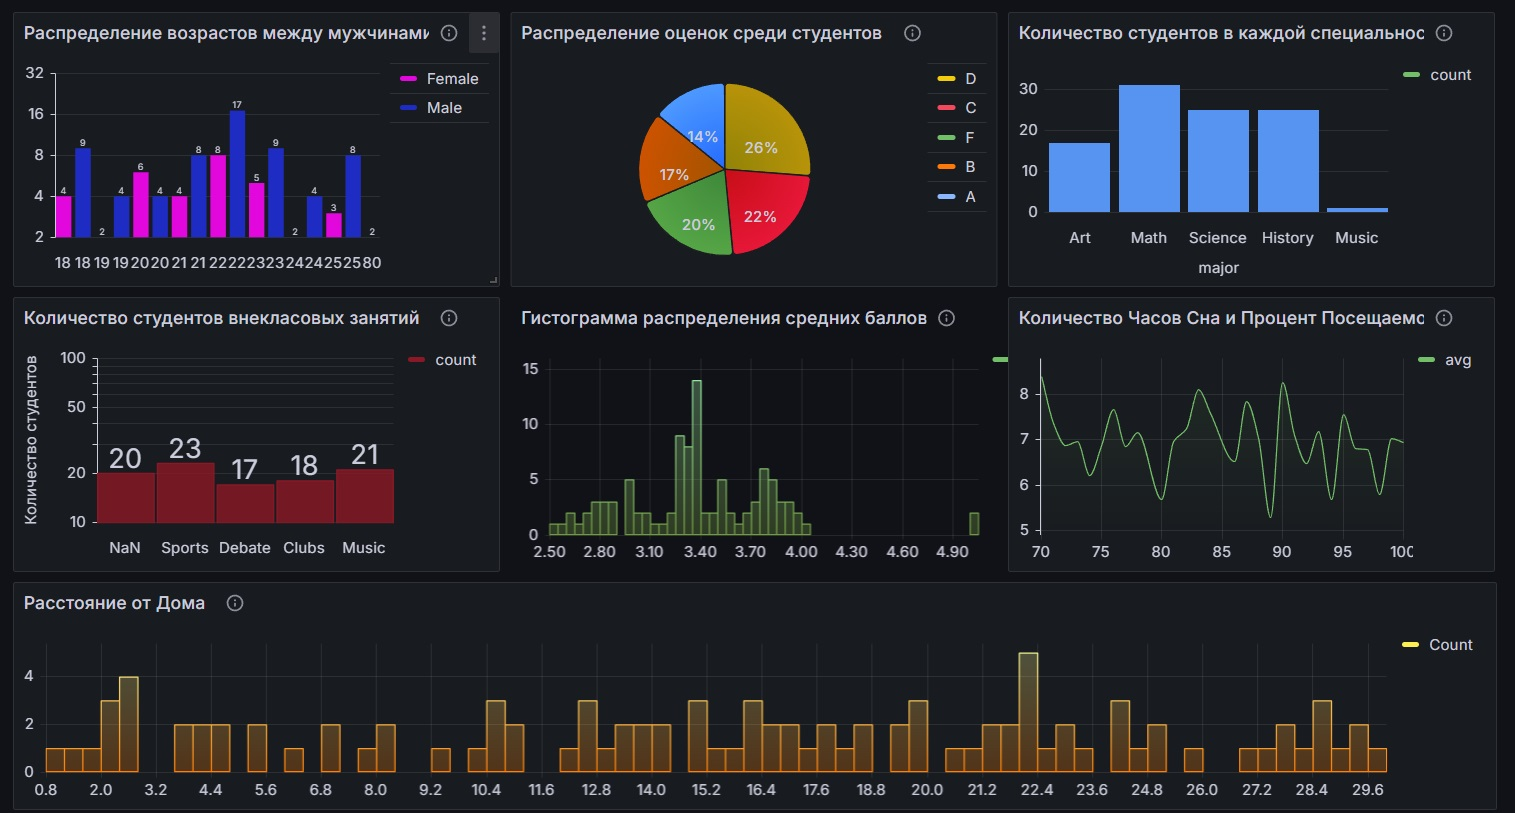

In [372]:

display(Image(filename='../images/Grafana_final.jpg'))